In [1]:
import numpy as np
import pandas as pd
import os
import pprint
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
import matplotlib
from os import listdir
import seaborn as sns
import scipy
import sys
import copy
import pickle
from scipy import stats

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

import warnings
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt

In [2]:
rs = 42

In [3]:
do_shap_scores = 0
do_soft_rankings = 1

### Loading in Files

In [4]:
os.chdir('..')

In [5]:
prediction_window = ""

In [6]:
data_directory = 'Sepsis Data/'
prediction_directory = 'sepsis/'
model_type = 'XGBoost'
num_features_to_look = 10

In [7]:
df_top_features = pd.read_csv(f"Sepsis Code/Feature Importances/{model_type}_" + prediction_window + "_SHAPImportantFeatures.csv")
df_top_features = df_top_features.loc[:, ~df_top_features.columns.str.contains('^Unnamed')]
df_top_features = df_top_features.iloc[0:num_features_to_look]

In [8]:
# Getting list of features and shape for eventual score dataframe
file = str(420) + '.csv'
data = pd.read_csv(data_directory + prediction_directory + "cleaned/" + file)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
feats_index = list(data)
feats_index.remove('sepsis_label')
# 7 hospitals, 1 aggregate
feats_score_shape = (len(feats_index), (7+1))

In [9]:
feat_ds_df = pd.read_csv('Sepsis Data/Feature_Dissimilarities.csv')

#### Using SHAP Scores

In [10]:
# Retired code
if do_shap_scores:
    from sklearn import preprocessing

    scaler = preprocessing.MinMaxScaler()
    min_max_scaler = preprocessing.MinMaxScaler()
    feat_scores_array = min_max_scaler.fit_transform(df_feat_scores)
    df_feat_scores = pd.DataFrame(feat_scores_array, columns=df_feat_scores.columns, index=df_feat_scores.index)

#### Using Soft Ranking Scores
Same methodology used in transportablity paper

In [11]:
if do_soft_rankings:
    init_data = np.zeros(feats_score_shape)
    df_soft_rankings = pd.DataFrame(data = init_data, columns=list(df_top_features), index=feats_index)

    s = df_top_features.shape[0] 
    features = np.unique(df_top_features.values)
    for feature in features:
        loc = np.where(df_top_features.values == feature)
        rows = loc[0]
        cols = loc[1]
        feature_index = df_soft_rankings.index.get_loc(feature)
        for i in range(0, len(cols)):
            df_soft_rankings.iloc[feature_index, cols[i]] = np.exp((-1 * (rows[i] + 1))/s)
    df_feat_scores = df_soft_rankings

### Analysis between Local Sites

In [12]:
df_top_features_local = df_top_features.drop(columns=['Agg'])
df_feat_scores_local = df_feat_scores.drop(columns=['Agg'])

features, counts = np.unique(df_top_features_local.values, return_counts=True)
props = counts/7
feature_site_props = {features[i]: props[i] for i in range(len(features))}

feature_col_dict = dict.fromkeys(features)
for feature in feature_col_dict:
    loc = np.where(df_top_features_local.values == feature)
    cols = loc[1]
    feature_col_dict[feature] = cols

feature_score_dict = dict.fromkeys(features)
for feature in feature_score_dict:
    idx = feature_col_dict[feature]
    feature_score_dict[feature] = df_feat_scores_local.iloc[:, idx].loc[feature].values

feature_mean_dict = dict.fromkeys(features)
for feature in feature_mean_dict:
    feature_mean_dict[feature] = np.mean(feature_score_dict[feature])
values = feature_mean_dict.values()

feature_iqr_dict = dict.fromkeys(features)
for feature in feature_score_dict:
    idx = feature_col_dict[feature]
    q75, q25 = np.percentile(idx, [75 ,25])
    iqr = q75 - q25
    feature_iqr_dict[feature] = iqr

#### Plotting Local Analyses

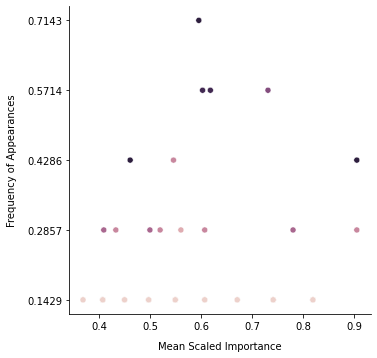

In [13]:
soft_importances = []
feature_frequency = []
features = []
iqrs = []
for feature in feature_mean_dict:
    soft_importances.append(feature_mean_dict[feature])
    feature_frequency.append(feature_site_props[feature])
    features.append(feature)
    iqrs.append(feature_iqr_dict[feature])

data_df = pd.DataFrame(data={'features':features, 'frequency':feature_frequency,
                             'score':soft_importances, 'IQR':iqrs})
x, y = data_df['score'].min(), data_df['score'].max()
data_df['scaled_score'] = (data_df['score'] - x) / (y - x)
data_df['unique_important_score'] = (1 - data_df['frequency']) * data_df['score']
data_df_local = copy.deepcopy(data_df)

g = sns.relplot(
    data=data_df,
    x="score", y="frequency", hue="IQR"
)
plt.yticks(np.unique(props))

# for i in range(data_df.shape[0]):
#     if data_df.score[i] > 0.9:
#         plt.text(x=data_df.score[i]+0.01,y=data_df.frequency[i]+0.01,s=data_df.features[i],
#                  fontdict=dict(color='black',size=10))

g.set_axis_labels("Mean Scaled Importance", "Frequency of Appearances", labelpad=10)
g._legend.remove()
# g.set(title='Local Feature Importances')

### Analysis with Aggregate Model

In [14]:
df_top_features_agg = df_top_features['Agg']
df_feat_scores_agg = df_feat_scores['Agg']

In [15]:
agg_feature_score_dict = dict.fromkeys(df_top_features_agg.values)
for feature in agg_feature_score_dict:
    agg_feature_score_dict[feature] = df_feat_scores_agg.loc[feature]

#### Plotting Aggregate Analysis

- Agg Model Feature Importances vs How Many Sites Had it As a Top 100 Feature
    - Should expect to be linear with a positive slope (assuming aggregate model uses features that more institutions use

Text(6.799999999999997, 0.5, 'Frequency of Appearances')

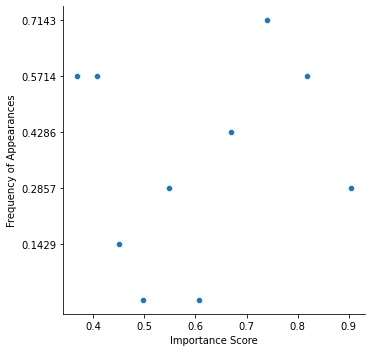

In [16]:
agg_importances = []
feature_frequency = []
features = []
for feature in agg_feature_score_dict:
    agg_importances.append(agg_feature_score_dict[feature])
    if feature in feature_site_props:
        feature_frequency.append(feature_site_props[feature])
    else:
        feature_frequency.append(0)
    features.append(feature)

data_df = pd.DataFrame(data={'features':features, 'frequency':feature_frequency, 'score':agg_importances})
x, y = data_df['score'].min(), data_df['score'].max()
data_df['scaled_score'] = (data_df['score'] - x) / (y - x)
data_df['unique_important_score'] = (1 - data_df['frequency']) * data_df['score']
data_df_agg = copy.deepcopy(data_df)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(agg_importances, feature_frequency)
my_rho = np.corrcoef(agg_importances, feature_frequency)

g = sns.relplot(
    data=data_df,
    x="score", y="frequency")
plt.yticks(np.unique(props))

# for i in range(data_df.shape[0]):
#     if data_df.score[i] > 0.9:
#         plt.text(x=data_df.score[i]+0.01,y=data_df.frequency[i]+0.01,s=data_df.features[i],
#                  fontdict=dict(color='black',size=10))

plt.xlabel("Importance Score")
plt.ylabel("Frequency of Appearances")
# plt.title("Agg Model Feature Importances vs How Many Sites Had it As a Top 100 Feature, PC = {}".format(np.round(my_rho[0, 1], 2)))

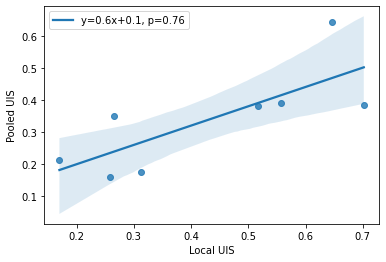

In [17]:
# Predicting Unique Importance of Model
inc_feats = ['features', 'unique_important_score']
df_data = pd.merge(data_df_agg[inc_feats], data_df_local[inc_feats], on='features')
df_data = df_data.rename(columns={'unique_important_score_x':'unique_important_score_agg', 'unique_important_score_y':'unique_important_score_local'})
slope, intercept, r_value, p_value, std_err = stats.linregress(df_data['unique_important_score_local'],df_data['unique_important_score_agg'])
my_rho = np.round(np.corrcoef(df_data['unique_important_score_local'], df_data['unique_important_score_agg'])[0, 1], 2)
ax = sns.regplot(x="unique_important_score_local", y="unique_important_score_agg", data=df_data,
                 line_kws={'label':"y={0:.1f}x+{1:.1f}, p={2:.2f}".format(slope, intercept, my_rho)})
ax.legend()
# plt.title("Local Unique Importance Scores vs Pooled Unique Importance Scores")
plt.xlabel("Local UIS")
plt.ylabel("Pooled UIS")
plt.show()

### Adding Federated Models

In [18]:
df_top_fed_features = pd.read_csv(f"Sepsis Code/Feature Importances/Federated {model_type}_" + prediction_window + "_SHAPImportantFeatures.csv")
df_top_fed_features = df_top_fed_features.loc[:, ~df_top_fed_features.columns.str.contains('^Unnamed')]
df_top_fed_features = df_top_fed_features.iloc[0:num_features_to_look]

In [19]:
if do_soft_rankings:
    init_data = np.zeros((len(feats_index), 1))
    df_soft_rankings = pd.DataFrame(data = init_data, columns=list(df_top_fed_features), index=feats_index)

    s = df_top_fed_features.shape[0] 
    features = np.unique(df_top_fed_features.values)
    for feature in features:
        loc = np.where(df_top_fed_features.values == feature)
        rows = loc[0]
        cols = loc[1]
        feature_index = df_soft_rankings.index.get_loc(feature)
        for i in range(0, len(cols)):
            df_soft_rankings.iloc[feature_index, cols[i]] = np.exp((-1 * (rows[i] + 1))/s)
    df_fed_feat_scores = df_soft_rankings

In [20]:
df_all_scores = pd.merge(df_feat_scores, df_fed_feat_scores, left_index=True, right_index=True)

In [21]:
df_all_scores.head()

,420,122,243,252,458,199,73,Agg,fed
heartrate_first,0.449329,0.670320,0.0,0.740818,0.0,0.548812,0.00000,0.367879,0.0
sysbp_first,0.000000,0.000000,0.0,0.000000,0.0,0.406570,0.00000,0.000000,0.0
diasbp_first,0.000000,0.000000,0.0,0.000000,0.0,0.449329,0.67032,0.000000,0.0
meanbp_first,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.0
resprate_first,0.548812,0.606531,0.0,0.818731,0.0,0.496585,0.00000,0.818731,0.0


#### Analysis with Federated Models

In [22]:
df_top_features_fed = df_top_fed_features['fed']
df_feat_scores_fed = df_all_scores['fed']

In [23]:
fed_feature_score_dict = dict.fromkeys(df_top_features_fed.values)
for feature in fed_feature_score_dict:
    fed_feature_score_dict[feature] = df_feat_scores_fed.loc[feature]

#### Plotting Federated Analysis

Text(6.799999999999997, 0.5, 'Frequency of Appearances')

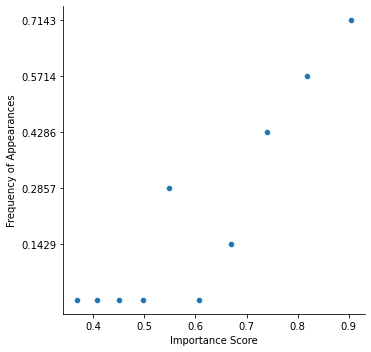

In [24]:
fed_importances = []
feature_frequency = []
features = []
for feature in fed_feature_score_dict:
    fed_importances.append(fed_feature_score_dict[feature])
    if feature in feature_site_props:
        feature_frequency.append(feature_site_props[feature])
    else:
        feature_frequency.append(0)
    features.append(feature)

data_df = pd.DataFrame(data={'features':features, 'frequency':feature_frequency, 'score':fed_importances})

x, y = data_df['score'].min(), data_df['score'].max()
data_df['scaled_score'] = (data_df['score'] - x) / (y - x)
data_df['unique_important_score'] = (1 - data_df['frequency']) * data_df['score']
data_df_fed = copy.deepcopy(data_df)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(fed_importances, feature_frequency)
my_rho = np.corrcoef(fed_importances, feature_frequency)

g = sns.relplot(
    data=data_df,
    x="score", y="frequency")
plt.yticks(np.unique(props))

plt.xlabel("Importance Score")
plt.ylabel("Frequency of Appearances")
# plt.title("Fed Model Feature Importances vs How Many Sites Had it As a Top 100 Feature, PC = {}".format(np.round(my_rho[0, 1], 2)))

In [ ]:
# Predicting Unique Importance of Model
inc_feats = ['features', 'unique_important_score']
df_data = pd.merge(data_df_fed[inc_feats], data_df_local[inc_feats], on='features')
df_data = df_data.rename(columns={'unique_important_score_x':'unique_important_score_fed', 'unique_important_score_y':'unique_important_score_local'})
slope, intercept, r_value, p_value, std_err = stats.linregress(df_data['unique_important_score_local'],df_data['unique_important_score_fed'])
my_rho = np.round(np.corrcoef(df_data['unique_important_score_local'], df_data['unique_important_score_fed'])[0, 1], 2)
ax = sns.regplot(x="unique_important_score_local", y="unique_important_score_fed", data=df_data,
                 line_kws={'label':"y={0:.1f}x+{1:.1f}, p={2:.2f}".format(slope,intercept,my_rho)})
ax.legend()
# plt.title("Local Unique Importance Scores vs Federated Unique Importance Scores")
plt.xlabel("Local UIS")
plt.ylabel("Federated UIS")
plt.show()